___
## Capstone 1: Liver Disease Prediction
### Inferential Statistics
___

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
#import clean data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None


,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,True
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,True
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,True
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,True
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,True


___
### Preconditions of the Central Limit Theorem

T-tests and z-tests, which rely on the assumption of normally distributed sampling statistics, will be used in the analyses to follow. Therefore, it is important to first establish that the preconditions of the Central Limit Theorem are satisfied for this data.

Since each observation is an individual patient, we can safely consider all observations to be independent. 

To ensure that the sample size is large enough for z-tests, there should be more than 10 observations of each combination of sex and liver disease group.

In [3]:
# sample size confirmation
male_df = liver_df[liver_df['sex'] == 'Male']
female_df = liver_df[liver_df['sex'] == 'Female']

n_male_disease = male_df['liver disease'].sum()
n_male_control = len(male_df['liver disease']) - n_male_disease

n_female_disease = female_df['liver disease'].sum()
n_female_control = len(female_df['liver disease']) - n_female_disease

print(n_male_disease, n_male_control, n_female_disease, n_female_control)

324 117 92 50


Since even the smallest group has 50 observations, the sample size in this dataset is enough to satisfy the normality assumption for all the t- and z-tests to follow.

___
### Correlation among predictive metrics

To explore whether the diagnostic metrics are significantly associated with each other, the matrix of correlation coefficients will be generated, along with all the corresponding p-values. The null hypothesis in each metric-to-metric comparison is that the two metrics do not covary.

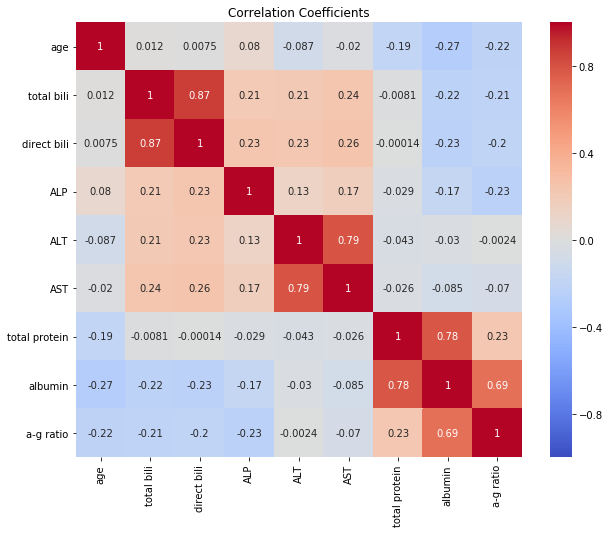

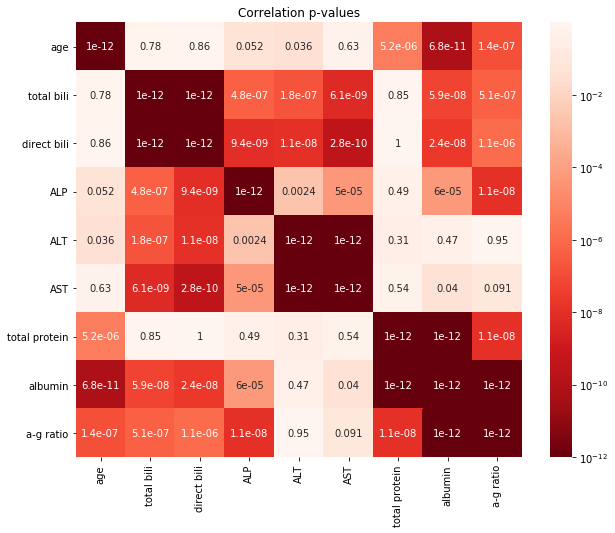

In [4]:
# visualize correlation matrix and p-values matrix
from matplotlib.colors import LogNorm

numeric_df = liver_df[['age', 'total bili', 'direct bili', 'ALP', 'ALT', 'AST', 'total protein', 
                       'albumin', 'a-g ratio']].copy()

def r_to_p(r, n=len(numeric_df.age), tails=2):
    ''' derive p-value of a Pearson correlation coefficient '''
    if r == 1:
        return 0
    
    t = r / ((1 - r**2)/(n - 2))**0.5
    p = tails * (1 - stats.t.cdf(abs(t), n-2))
    return p



# correlation matrix heatmap
corr = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0, cmap='coolwarm', annot=True, 
            vmin=-1, vmax=1)
plt.title('Correlation Coefficients')
plt.savefig('correlation_matrix.png')
plt.show()

# generate log-scaled p-values matrix heatmap
corr_p = corr.applymap(r_to_p)
corr_p = corr_p.applymap(lambda p: 1e-12 if p==0 else p) #log scale will not work with entries of 0
plt.figure(figsize=(10,8))
sns.heatmap(corr_p, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Reds_r', annot=True,
            norm=LogNorm(vmin=corr_p.min(), vmax=corr_p.max()), 
            cbar_kws={'ticks':[1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]})
plt.title('Correlation p-values')
plt.show()

The correlation matrix shows mostly weak correlations. 

The liver enzyme tests (ALP, ALT, AST) are all at least weakly associated with each other, with statistically-significant p-values (all p < 0.01). A particularly strong association exists between AST and ALT. This may indicate that their concentration in the blood is connected by similar homeostatic processes and similar response to disease states, and therefore the two measures might have overlapping diagnostic significance. ALP has only weak associations with the other liver enzymes, indicating that it may have unique diagnostic value in this group.

Within the blood protein measures (total protein, albumin, and a-g ratio), albumin is strongly associated with the other two measures. This is not surprising, given that albumin makes up a large proportion of total blood protein, and is the numerator in albumin-globulin ratio. Total protein and a-g ratio are only weakly correlated. All correlations are statistically significant with p < 10^-7.

Total and direct bilirubin are also strongly correlated, which is not surprising given that these are two measures of the same thing (bilirubin concentration in the blood).

___
### Association of sex with the numeric metrics

To investigate whether each of the numeric metrics is significantly related to sex, t-tests will be performed to compare men and women across each metric. The null hypothesis in each case will be that there is no difference in the mean of the metric between men and women.

In [5]:
# split dataset into men and women
male_df = liver_df[liver_df['sex'] == 'Male']
female_df = liver_df[liver_df['sex'] == 'Female']

num_metrics = ['age', 'total bili', 'direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'albumin', 'a-g ratio']

# initialize results df
sex_ttest_results = pd.DataFrame(num_metrics)
sex_ttest_results.set_index(0, inplace=True)
sex_ttest_results.index.name = 'diagnostic metric'

# run t-tests
for metric in num_metrics:
    t, p = stats.ttest_ind(male_df[metric], female_df[metric])
    sex_ttest_results.loc[metric, 'male mean'] = male_df[metric].mean()
    sex_ttest_results.loc[metric, 'female mean'] = female_df[metric].mean()
    sex_ttest_results.loc[metric, 't-statistic'] = t
    sex_ttest_results.loc[metric, 'p-value'] = p

sex_ttest_results

,male mean,female mean,t-statistic,p-value
diagnostic metric,,,,
age,45.265306,43.133803,1.365511,0.172621
total bili,3.613152,2.322535,2.160892,0.031112
direct bili,1.646032,0.989437,2.433218,0.015266
ALP,286.789116,302.338028,-0.663017,0.507583
ALT,89.238095,54.239437,1.991292,0.046917
AST,123.070295,69.042254,1.942699,0.052535
total protein,6.428345,6.653521,-2.156751,0.031435
albumin,3.099546,3.273239,-2.270944,0.023515
a-g ratio,0.946449,0.948973,-0.082046,0.934639


The results of these t-tests indicate that bilirubin, total protein, and albumin are significantly different between men and women in this dataset. We cannot rule out the null hypothesis in the case of age, ALP, and a-g ratio. ALT and AST have p-values that are close to the threshold of significance, with ALT having a p-value slightly below the threshold, and AST having a p-value slightly above.

___
### Relationships of the numeric diagnostic metrics to liver disease 

To investigate whether each of the numeric metrics is significantly related to the presence of liver disease, t-tests will be performed to compare the group with liver disease to the control group across each metric. The null hypothesis in each case will be that there is no difference in the mean of the metric between those with liver disease and those without liver disease.

In [6]:
# split dataset into liver disease groups
disease_df = liver_df[liver_df['liver disease'] == True]
control_df = liver_df[liver_df['liver disease'] == False]

# initialize results df
ttest_results = pd.DataFrame(num_metrics)
ttest_results.set_index(0, inplace=True)
ttest_results.index.name = 'diagnostic metric'

# run t-tests
for metric in num_metrics:
    t, p = stats.ttest_ind(disease_df[metric], control_df[metric])
    ttest_results.loc[metric, 'liver patient mean'] = disease_df[metric].mean()
    ttest_results.loc[metric, 'control mean'] = control_df[metric].mean()
    ttest_results.loc[metric, 't-statistic'] = t
    ttest_results.loc[metric, 'p-value'] = p

ttest_results


,liver patient mean,control mean,t-statistic,p-value
diagnostic metric,,,,
age,46.153846,41.239521,3.342369,8.840632e-04
total bili,4.164423,1.142515,5.441441,7.801431e-08
direct bili,1.923558,0.396407,6.118790,1.734103e-09
ALP,319.007212,219.754491,4.534141,7.027487e-06
ALT,99.605769,33.652695,3.992646,7.371781e-05
AST,137.699519,40.688623,3.705217,2.313901e-04
total protein,6.459135,6.543114,-0.844354,3.988191e-01
albumin,3.060577,3.344311,-3.941755,9.074361e-05
a-g ratio,0.914337,1.028588,-3.965115,8.251144e-05


All numeric metrics, with the exception of total protein, are significantly different in the disease and control groups. Age, bilirubin, ALP, ALT, and AST are all higher in the disease group, while albumin and a-g ratio are lower in the disease group. Since these tests are used to diagnose liver disease, it makes sense that they would be associated with a liver disease diagnosis in a statistically-significant way. 

Total protein is the exception here, and the fact that it is not significantly associated with a liver disease diagnosis raises questions about its utility here. When the machine learning model is trained, it may be worthwhile to investigate the model's performance with and without this feature included.

___
### Association of sex with liver disease diagnosis

A proportions z-test will be used to investigate whether there is an association between sex and liver disease in this dataset. The proportion of men will be compared between controls and liver patients, with the null hypothesis that there is no difference in proportion of men in the two groups.


In [8]:
from statsmodels.stats.proportion import proportions_ztest

control_obs = len(control_df['liver disease'])
disease_obs = len(disease_df['liver disease'])

n_males = (n_male_disease, n_male_control)
n_obs = (disease_obs, control_obs)

disease_prop = n_male_disease/disease_obs
control_prop = n_male_control/control_obs

zstat, p_value = proportions_ztest(n_males, n_obs, value=0)

print('Proportion men in liver patients: ', disease_prop)
print('Proportion men in controls: ', control_prop)
print('\n')

print('Z-test for proportions:')
print('z-statistic: ', zstat)
print('p-value: ', p_value)

Proportion men in liver patients:  0.7788461538461539
Proportion men in controls:  0.7005988023952096


Z-test for proportions:
z-statistic:  1.9899646317394701
p-value:  0.04659483172747257


From the z-test it can be concluded that the proportion of men is different between liver patients and controls in this dataset. However, it is important to note that this may be a result of sampling bias. A more in-depth inspection of the sampling methods used to collect this data set is needed before concluding that male sex may be associated with higher risk of liver disease.
___